In [1]:
import NearestNeighbors
using StaticArrays
using PGFPlots

In [2]:
import NearestNeighbors: TreeData

# Define RTree type

In [3]:
struct HyperRectangle{N}
    mins::SArray{Tuple{N,1},Float64}
    maxes::SArray{Tuple{N,1},Float64}
end
function HyperRectangle(A::AbstractVector,B::AbstractVector)
    HyperRectangle(
        SArray{Tuple{size(A)[1],1},Float64}(A),
        SArray{Tuple{size(B)[1],1},Float64}(B))
end
function HyperRectangle(A::AbstractArray)
    HyperRectangle(
        SArray{Tuple{size(A)[1],1},Float64}(minimum(A,2)),
        SArray{Tuple{size(A)[1],1},Float64}(maximum(A,2)))
end
function Union(H1::HyperRectangle{N}, H2::HyperRectangle{N}) where N
    HyperRectangle(min.(H1.mins, H2.mins), max.(H1.maxes, H2.maxes))
end
function Intersection(H1::HyperRectangle{N}, H2::HyperRectangle{N}) where N
    HyperRectangle(max.(H1.mins, H2.mins), min.(H1.maxes, H2.maxes))
end
function ComputeVolume(H::HyperRectangle{N}) where N
    prod(H.maxes .- H.mins)
end
function CheckIntersection(H1::HyperRectangle{N},H2::HyperRectangle{N}) where N
    return (ComputeVolume(Intersection(H1,H2)) > 0)
end
function CheckIntersection(H::HyperRectangle{N}, Q::Array{Float64,2}) where N
    HQ = HyperRectangle(Q)
    CheckIntersection(H,HQ)
end
struct LeafNode{N}
    id::Int
    object_ids::Array{Int,1}
    rect::HyperRectangle{N}
end
struct InternalNode{N}
    id::Int
    children::Array{Int,1}
    parent::Int
    rect::HyperRectangle{N}
end
function InternalNode(node::InternalNode{N},H::HyperRectangle{N}) where N
    InternalNode(node.id,node.children,node.parent,H)
end

InternalNode

In [4]:
function drawBox(rec::HyperRectangle)
    if length(rec.mins) == 2
        return [
            Plots.Linear([rec.mins[1], rec.mins[1], rec.maxes[1], rec.maxes[1], rec.mins[1]],
                [rec.mins[2],rec.maxes[2],rec.maxes[2],rec.mins[2], rec.mins[2]], mark="none")
        ]
    end
end
function compute_bounding_box(data)
    mins = minimum(data,2)[:]
    maxes = maximum(data,2)[:]
    HyperRectangle(mins,maxes)
end

compute_bounding_box (generic function with 1 method)

In [5]:
type RTree{N}
    objects::Array{HyperRectangle{N},1}
    root_node::InternalNode{N}
    nodes::Dict{Int64, InternalNode{N}}
    num_nodes::Int64
end

In [6]:
X1 = rand(2,4)
X2 = rand(2,4)
H1 = HyperRectangle(X1)
H2 = HyperRectangle(X2)
H3 = Intersection(H1,H2)
H4 = Union(H1,H2)

HyperRectangle{2}([0.067099; 0.00439878], [0.994684; 0.898351])

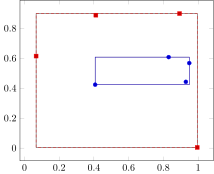

In [7]:
elements = vcat([
        Plots.Linear(X1[1,:],X1[2,:],onlyMarks=true),
        Plots.Linear(X2[1,:],X2[2,:],onlyMarks=true),
        drawBox(H1),drawBox(H2),drawBox(H3),drawBox(H4)
        ]...)
Axis(elements)

# Construct RTree

In [8]:
struct Node{N}
    id::Int
    rec::HyperRectangle{N}
    parent::Int
    children::Set{Int}
    is_leaf::Bool
end

In [10]:
Node(1,HyperRectangle([0.0,0.0],[0.0,0.0]),-1,Set{Int}(),true)

Node{2}(1, HyperRectangle{2}([0.0; 0.0], [0.0; 0.0]), -1, Set{Int64}(), true)

In [13]:
# initialize root node
root_node = Node(0,HyperRectangle([0.0,0.0],[0.0,0.0]),-1,Set{Int}(),false)
nodes = Dict()
nodes[0] = root_node
# Add each leaf node, splitting as we go
objects = [rand(2,4) .+ 10*rand(2,1) - 5 for i in 1:100];
for (i,object) in enumerate(objects)
    nodes[i] = Node(i,compute_bounding_box(object),-1,Set{Int}())
end

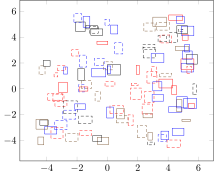

In [17]:
elements = vcat([drawBox(node.rec) for node in values(nodes)]...)
Axis(elements)

In [ ]:
frontier = Set(collect(1:length(objects)))
explored = Set()
M = 4
m = 1

next_id = root_node.id + 1

while length(frontier) > 0
    object_id = pop!(frontier)
    push!(object_id, explored)
    
    parent = nodes[0] # root node
    
    # traverse tree and determine where to add node
    node = root_node
    
    eligible_nodes = []
    if length(node.children) < M
        next_node = InternalNode(next_id, Array{Int,1}(), node.id, object_rects[object_id])
        rtree.nodes[next_node.id] = next_node
    else
        ΔV = [ComputeVolume(Union(H, next_node.rect)) - ComputeVolume(next_node.rect) for next_node in node.children]
        insertion_rank = sortperm(ΔV)
        for next_node in node.children
        end
    end

    
end

In [ ]:
Q = rand(object_rects)

In [ ]:
function RangeSearch(rtree, root_node, Q)
    """
    Searches through the tree and returns all nodes whose bounding hyper-rectangle intersects with query Q
    """
    frontier = Set(root_node.id)
    intersections = Set()
    explored = Set()

    while length(frontier) > 0
        node_id = pop!(frontier)
        node = rtree.nodes[node_id]
        for child_node_id in node.children
            child_node = rtree.nodes[child_node_id]
            if CheckIntersection(child_node.rect, Q)
                push!(frontier, child_node_id)
            end
        end
        push!(explored, node_id)
    end
    return explored
end

In [ ]:
function getLocalIntersections(rtree, root_node, Q)
    if length(root_node.children) > 0
        ΔV = Array{Float64,1}(
            [ComputeVolume(Intersection(H, node.rect)) - ComputeVolume(node.rect) for node in root_node.children])
        intersection_ids = root_node.children[ΔV > 0]
        ΔV = ΔV[ΔV > 0]
        return intersections, ΔV
    else
        return Array{Int64,1}(),Array{Float64,1}()
    end
end
function ComputeLocalUnionVolumes(rtree, root_node, Q)
    if length(root_node.children) > 0
        ΔV = Array{Float64,1}(
            [ComputeVolume(Union(H, node.rect)) - ComputeVolume(node.rect) for node in root_node.children])
        return ΔV
    else
        return Array{Float64,1}()
    end
end

In [ ]:
explored_ids = RangeSearch(rtree, root_node, Q)

In [ ]:
getLocalIntersections(rtree, root_node, Q)

# Construct RTree

In [ ]:

root_node = HyperRectangle([0.0,0.0],[0.0,0.0])

In [ ]:
clusters = [rand(2,10) .+ 5*rand(2,1) for i in 1:20]
bboxes = [compute_bounding_box(c) for c in clusters]
Axis(
    vcat(
        [Plots.Linear(cluster[1,:],cluster[2,:],onlyMarks=true) for cluster in clusters]...,
        [drawBox(b) for b in bboxes]...
    )
)

In [ ]:
struct RNode
    id::Int
    parent::Int
    children::Set{Int}
    rect::HyperRectangle
end

In [ ]:
nodes = Dict()
for (i,c) in enumerate(clusters)
    nodes[i] = RNode(i,0,Set(),compute_bounding_box(c))
end